In [150]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools

import data.data
import interactions
import lattice
import importlib
importlib.reload(lattice)
importlib.reload(interactions)
importlib.reload(data.data)

<module 'data.data' from '/n/home10/jmcgreivy/LatticeNuclearModel/data/data.py'>

In [151]:
def get_interactions(a_mm_0, a_mm_1, a_mm_2, a_mm_3,
                     a_mp_0, a_mp_1, a_mp_2, a_mp_3,
                     a_pm_0, a_pm_1, a_pm_2, a_pm_3,
                             a_pp_1, a_pp_2, a_pp_3,
                     a_c_1, a_c_2):
    a_pp_0 = a_pp_1
    # Package into lists
    a_list_mm = [a_mm_0, a_mm_1, a_mm_2, a_mm_3,]
    a_list_mp = [a_mp_0, a_mp_1, a_mp_2, a_mp_3,]
    a_list_pm = [a_pm_0, a_pm_1, a_pm_2, a_pm_3,]
    a_list_pp = [a_pp_0, a_pp_1, a_pp_2, a_pp_3,]
    a_list_coulomb = [a_c_1, a_c_2]
    
    return interactions.get_nuclear_interaction(a_list_mm), interactions.get_nuclear_interaction(a_list_mp), interactions.get_nuclear_interaction(a_list_pm), interactions.get_nuclear_interaction(a_list_pp), interactions.get_coulomb_interaction(a_list_coulomb), interactions.build_full_interaction(a_list_mm, a_list_mp, a_list_pm, a_list_pp, a_list_coulomb)
    

In [152]:
best = {"target": -3.741057959599389, 
        "params": 
        {
         "a_c_1": 20.0, "a_c_2": 9.0, 
         "a_mm_0": 10.0, "a_mm_1": 10.0, "a_mm_2": 10.0, "a_mm_3": 10.0,
         "a_mp_0": 10.0, "a_mp_1": 10.0, "a_mp_2": 10.0, "a_mp_3": 10.0,
         "a_pm_0": 10.0, "a_pm_1": 10.0, "a_pm_2": 10.0, "a_pm_3": 10.0,
         "a_pp_1": 10.0, "a_pp_2": 10.0, "a_pp_3": 10.0
        },
        "datetime": {"datetime": "2024-07-12 00:49:41", "elapsed": 45748.108213, "delta": 1367.894783}}

f_nuclear_mm, f_nuclear_mp, f_nuclear_pm, f_nuclear_pp, f_coulomb, f_full = get_interactions(**best["params"])

Text(0.5, 1.0, 'Coulomb Force')

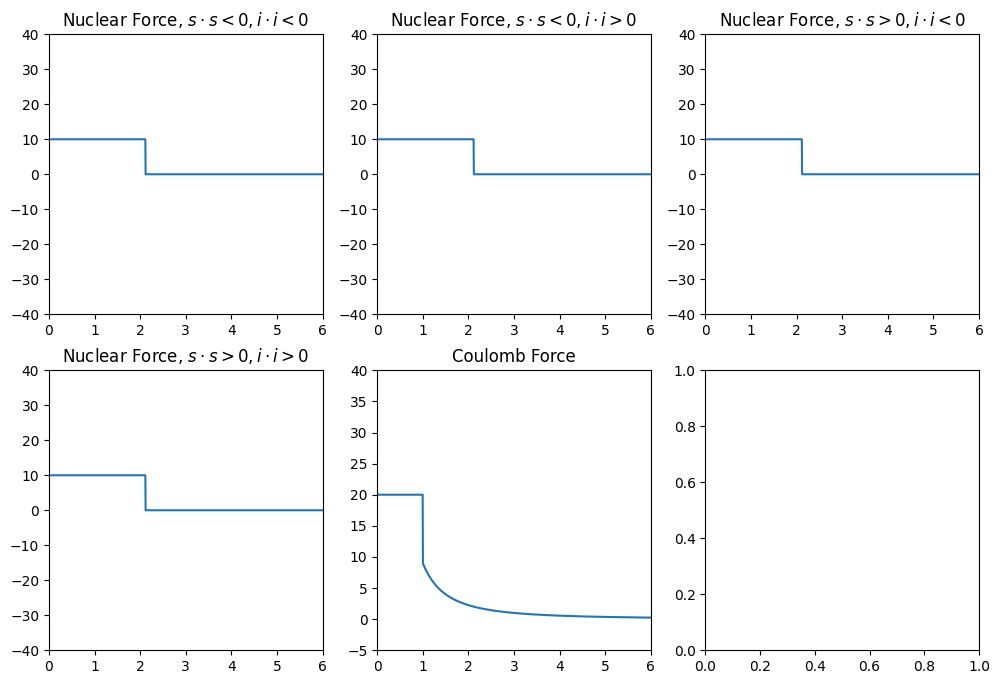

In [153]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

x = torch.linspace(0, 6, 1000)

y_lim = (-40, 40)
y_lim_c = (-5, 40)

axs[0,0].plot(x, f_nuclear_mm(x))
axs[0,0].set_ylim(*y_lim)
axs[0,0].set_xlim(0, 6)
axs[0,0].set_title("Nuclear Force, $s \cdot s < 0, i \cdot i < 0$")

axs[0,1].plot(x, f_nuclear_mp(x))
axs[0,1].set_ylim(*y_lim)
axs[0,1].set_xlim(0, 6)
axs[0,1].set_title("Nuclear Force, $s \cdot s < 0, i \cdot i > 0$")

axs[0,2].plot(x, f_nuclear_pm(x))
axs[0,2].set_ylim(*y_lim)
axs[0,2].set_xlim(0, 6)
axs[0,2].set_title("Nuclear Force, $s \cdot s > 0, i \cdot i < 0$")

axs[1,0].plot(x, f_nuclear_pp(x))
axs[1,0].set_ylim(*y_lim)
axs[1,0].set_xlim(0, 6)
axs[1,0].set_title("Nuclear Force, $s \cdot s > 0, i \cdot i > 0$")

axs[1,1].plot(x, f_coulomb(x))
axs[1,1].set_ylim(*y_lim_c)
axs[1,1].set_xlim(0, 6)
axs[1,1].set_title("Coulomb Force")

In [154]:
Z = 26
N = 30
V_interaction = f_full
device = "cpu"

lat = lattice.NuclearLattice(Z, N, V_interaction, boundaries=[[-10, 10], [-10, 10], [-10, 10]], device=device)

In [155]:
import optimize_interactions
importlib.reload(optimize_interactions)

a_list_mm, a_list_mp, a_list_pm, a_list_pp, a_list_coulomb = [-39.99313751095931, -21.860045642089613, -31.194646550973218, -34.45968431387213], [-28.824387317339745, -19.266356377417136, -16.193951546159802, -7.6709959597985815], [-14.848329135802313, 1.1131700238055728, -27.732865016108953, 12.687046183456722], [-38.35674440812443, -38.35674440812443, 0.22805061070413046, -14.961711857972382], [8.34044009405148, 7.203244934421581]

z_min = 26
z_max = 26

dat = data.data.get_nuclear_data()
dat = dat[(dat['z'] >= z_min) & (dat['z'] <= z_max)]


for Z, N in zip(dat['z'], dat['n']):
    print(Z, N)
    binding = optimize_interactions.get_equilibrium_binding_mse((N, Z, a_list_mm, a_list_mp, a_list_pm, a_list_pp, a_list_coulomb, device))
    print(binding)
    break

26 19
361048.4727063313


In [142]:
#Z, N = 19, 16
Z, N = 26, 33

f_full = interactions.build_full_interaction(a_list_mm, a_list_mp, a_list_pm, a_list_pp, a_list_coulomb)
lat = lattice.NuclearLattice(Z, N, f_full, boundaries=[[-8, 8], [-8, 8], [-8, 8]])

In [143]:
E_tot = torch.inf
while True:
    lat.step()
    E_tot_new = lat.E_tot()
    if E_tot_new < E_tot:
        E_tot = E_tot_new
        print(E_tot)
    elif E_tot_new > E_tot + 1e-6:
        print("ERROR")
    else:
        break

-36479.890625
-40352.4140625
-41945.21875
-42182.1953125
-42558.68359375


In [109]:
state1 = torch.clone(lat.states)

In [113]:
state2 = torch.clone(lat.states)

In [114]:
state1 - state2

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0